# Assignment #5

# 1. Distance between two points (25 points)

In homework 2, we found using the spherical law of cosines, that the arc length between Durham and Chicago is 998.233 km. If we first project the geographical coordinates of the two cities onto a 2d plane, we should, in principle, be able to use the euclidean distance to calculate the distance between the two cities. Using this approach, calculate the distance between Durham and Chicago using the following three map projections. Provide a one paragraph explanation of how the computed distances differ.

* Oblique Azimuthal equidistant
* Mercator
* Cylindrical Equal Area

Items to keep in mind:
* Only Numpy can be used for this problem. The use of other geospatial software or libraries will not be accepted.
* The forward transformations for the three projections can be found in the book "Map Projections--A Working Manual" which is included in the folder "Other" in the GitHub repository under the filename "Snyder1987.pdf".
* The geographic coordinates of Durham, NC are 35.9940$^o$ N and 78.8986$^o$ W. The coordinates of Chicago, IL are 41.8781$^o$ N and 87.6298$^o$ W.


In [1]:
import numpy as np

def project_mercator(phis,lamda0,lamda,phi,Re):
    phis = phis*np.pi/180.0 #convert to radians
    lamda0 = lamda0*np.pi/180.0 #convert to radians
    lamda = lamda*np.pi/180.0 #convert to radians
    phi = phi*np.pi/180.0 #convert to radians
    x = Re*(lamda - lamda0*np.cos(phis))
    y = Re*np.sin(phi)/np.cos(phis)
    return (x,y)

def project_cylindrical_equal_area(phis,lamda0,lamda,phi,Re):
    phis = phis*np.pi/180.0 #convert to radians
    lamda0 = lamda0*np.pi/180.0 #convert to radians
    lamda = lamda*np.pi/180.0 #convert to radians
    phi = phi*np.pi/180.0 #convert to radians
    x = Re*(lamda - lamda0)*np.cos(phis)
    y = Re*np.sin(phi)/np.cos(phis)
    return (x,y)

def project_oblique_azimuthal_equidistant(phi1,lamda0,lamda,phi,Re):
    phi1 = phi1*np.pi/180.0 #convert to radians
    lamda0 = lamda0*np.pi/180.0 #convert to radians
    lamda = lamda*np.pi/180.0 #convert to radians
    phi = phi*np.pi/180.0 #convert to radians
    c = np.arccos(np.sin(phi1)*np.sin(phi) + np.cos(phi1)*np.cos(phi)*(np.cos(lamda-lamda0)))
    if np.cos(c) != 1.0:
        kprime = c/np.sin(c)
        x = Re*kprime*np.cos(phi)*np.sin(lamda-lamda0)
        y = Re*kprime*(np.cos(phi1)*np.sin(phi) - np.sin(phi1)*np.cos(phi)*np.cos(lamda-lamda0))
    else:
        x = 0.0
        y = 0.0
    return (x,y)

#Mercator projection
lamda0 = -78.8986 #central meridian
phis = 35.9940 #standard parallel
Re = 6371.0
#Durham
lamda = -78.8986
phi = 35.9940
(x_durham,y_durham) = project_mercator(phis,lamda0,lamda,phi,Re)
#Chicago
lamda = -87.6298
phi = 41.8781
(x_chicago,y_chicago) = project_mercator(phis,lamda0,lamda,phi,Re)
#calculate euclidean distance
print('Distance via Mercator:',((x_durham-x_chicago)**2 + (y_chicago-y_chicago)**2)**0.5)

#Cylindrical equal area projection
lamda0 = -78.8986 #central meridian
phis = 35.9940 #standard parallel
Re = 6371.0
#Durham
lamda = -78.8986
phi = 35.9940
(x_durham,y_durham) = project_cylindrical_equal_area(phis,lamda0,lamda,phi,Re)
#Chicago
lamda = -87.6298
phi = 41.8781
(x_chicago,y_chicago) = project_cylindrical_equal_area(phis,lamda0,lamda,phi,Re)
#calculate euclidean distance
print('Distance via Cylindrical Equal Area:',((x_durham-x_chicago)**2 + (y_durham-y_chicago)**2)**0.5)

#Azimuthal equidistant
lamda0 = -78.8986 #central meridian
phi1 = 35.9940 #standard parallel
Re = 6371.0
#Durham
lamda = -78.8986
phi = 35.9940
(x_durham,y_durham) = project_oblique_azimuthal_equidistant(phi1,lamda0,lamda,phi,Re)
#Chicago
lamda = -87.6298
phi = 41.8781
(x_chicago,y_chicago) = project_oblique_azimuthal_equidistant(phi1,lamda0,lamda,phi,Re)
#calculate euclidean distance
print('Distance via Oblique Azimuthal Equidistant:',((x_durham-x_chicago)**2 + (y_durham-y_chicago)**2)**0.5)

Distance via Mercator: 970.8651435189718
Distance via Cylindrical Equal Area: 1006.1544363419841
Distance via Oblique Azimuthal Equidistant: 998.2333233016451


The Oblique Azimuthal Equidistant is almost an exact match to the arc length calculated via the law of cosines. This is because this projection centered on Durham has the property that the distances to any point radially away from the center of projection (defined as Durham here) are accurate and not distorted.

# 2. Calculating the correct spatial mean (25 pts)

A simple spatial mean of a regular lat/long grid (Plate Carree) can lead to large discrepancies in the estimated spatial mean. To assess this impact, we are going to use the variable `t2m` in the annual ERA-Interim database (`/data/era-interim/era_interim_monthly_197901_201512_upscaled.nc_ann`). Start by assembling an array of actual area per pixel and then compute for each year the area weighted mean. Then compare the resulting time series to that resulting from using the equally weighted spatial mean (i.e., naive approach). Provide an explanation of your results.

In [6]:
%matplotlib inline
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
file_era_interim = '/data/era-interim/era_interim_monthly_197901_201512_upscaled.nc_ann'
fpe = nc.Dataset(file_era_interim)
#Extract the lats and lons array
lat = fpe['lat'][:]
lon = fpe['lon'][:]
#Read in the temperature data
data = fpe['t2m'][:]

In [7]:
#Compute the global map of true pixel area
def surface_area(Re,phi_a,phi_b,lambda_c,lambda_d):
    #Convert to radians
    phi_a = phi_a*np.pi/180.0
    phi_b = phi_b*np.pi/180.0
    lambda_c = lambda_c*np.pi/180.0
    lambda_d = lambda_d*np.pi/180.0
    tmp = Re**2*np.abs(np.sin(phi_a)-np.sin(phi_b))*np.abs(lambda_c - lambda_d)
    #Calculate surface area
    return Re**2*np.abs(np.sin(phi_a)-np.sin(phi_b))*np.abs(lambda_c - lambda_d)

Re = 6371.0 #km
#Initialize the area array
area = np.zeros((data.shape[1],data.shape[2]))
#Iterate per column and place the surface area
phi_a = lat - (lat[1]-lat[0])/2
phi_b = lat + (lat[1]-lat[0])/2
#Define res
res = lon[1] - lon[0]
for i in range(area.shape[1]):
    lambda_c = lon[i] - res/2
    lambda_d = lon[i] + res/2
    tmp = surface_area(Re,phi_a,phi_b,lambda_c,lambda_d)
    area[:,i] = surface_area(Re,phi_a,phi_b,lambda_c,lambda_d)   

In [8]:
#Calculate area-weighted spatial mean
weighted_mean = []
for i in range(data.shape[0]):
    weighted_mean.append(np.sum(area*data[i,:,:]/np.sum(area)))
weighted_mean = np.array(weighted_mean)
#Calculate equally weighted spatial mean
mean = np.mean(np.mean(data,axis=1),axis=1)

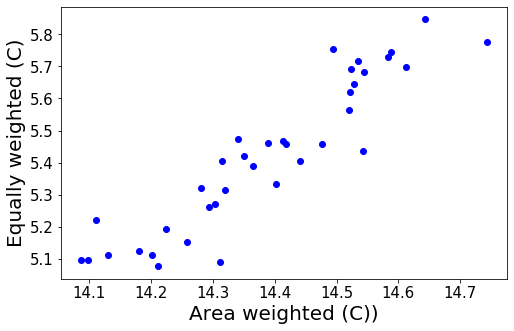

In [9]:
plt.figure(figsize=(8,5))
plt.plot(weighted_mean,mean,'bo')
plt.xlabel('Area weighted (C))',fontsize=20)
plt.ylabel('Equally weighted (C)',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

Not adequately accounting for area can have a very strong impact on the estimated time series. In this case, the difference impacts both the bias as well as the correlation. When using areal weighted average, the tropics have a much higher influence than the poles leading to a very large increase in the estimated global temperature. 

# 3. Reprojecting a reprojection (25 pts)

Extract the bounding box defined below from the NED elevation dataset ('/data/NED/NED.vrt') at a 0.01 arcdegree spatial resolution to a file named "dem_subset.tif". Then reproject the resulting file to a global Mollweide projection ("+proj=moll +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs") at a 2000 meter spatial resolution; name this file "dem_subset_mollweide.tif". Then reproject this resulting file back to the map projection of "dem_subset.tif"; name this file "dem_subset_reproduced.tif". The geospatial metadata of "dem_subset.tif" and "dem_subset_reproduced.tif" should be identical. Read both "dem_subset.tif" and "dem_subset_reproduced.tif" into Python and compare the two maps. To analyze the differences, plot the difference between the two maps and compute the RMSE and absolute BIAS between the two. If there any differences, explain the reason for the differences. Explain what you learn about the danger of reprojecting data too many times.

Bounding box coordinates:

* minlon = -107.5
* maxlon = -103.5
* minlat = 38.25
* maxlat = 40.25

Things to keep in mind:

* Be careful with the initial subset of the NED data. If not done correctly, you will crash your Docker container. Make sure that you are appropriately specifying the bounding box and the desired spatial resolution. I recommend starting off with a smaller region to become familiar with using `gdalwarp` first. 
* For all subset and reprojection operations, use the nearest neighbor interpolation scheme (`-r nearest`)

In [10]:
%%bash
#Extract the data from the bounding box
gdalwarp -overwrite -tr 0.01 0.01 -te -107.5 38.25 -103.5 40.25 /data/NED/NED.vrt ../Workspace/dem_subset.tif

Creating output file that is 400P x 200L.
Processing /data/NED/NED.vrt [1/1] : 0Using internal nodata values (e.g. -99999) for image /data/NED/NED.vrt.
Copying nodata values from source /data/NED/NED.vrt to destination ../Workspace/dem_subset.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


In [11]:
%%bash 
#Reproject to a global mollweide
gdalwarp -overwrite -tr 2000 2000 -t_srs "+proj=moll +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs" ../Workspace/dem_subset.tif ../Workspace/dem_subset_mollweide.tif

Creating output file that is 252P x 112L.
Processing ../Workspace/dem_subset.tif [1/1] : 0Using internal nodata values (e.g. -99999) for image ../Workspace/dem_subset.tif.
Copying nodata values from source ../Workspace/dem_subset.tif to destination ../Workspace/dem_subset_mollweide.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


pj_obj_create: Open of /opt/conda/share/proj failed
pj_obj_create: Open of /opt/conda/share/proj failed
pj_obj_create: Open of /opt/conda/share/proj failed
pj_obj_create: Open of /opt/conda/share/proj failed
pj_obj_create: Open of /opt/conda/share/proj failed


In [97]:
%%bash 
#Use gdalinfo to learn about original subsetted files geospatial metadata
gdalinfo ../Workspace/dem_subset.tif

Driver: GTiff/GeoTIFF
Files: ../Workspace/dem_subset.tif
Size is 400, 200
Coordinate System is:
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433],
    AUTHORITY["EPSG","4326"]]
Origin = (-107.500000000000000,40.250000000000000)
Pixel Size = (0.010000000000000,-0.010000000000000)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (-107.5000000,  40.2500000) (107d30' 0.00"W, 40d15' 0.00"N)
Lower Left  (-107.5000000,  38.2500000) (107d30' 0.00"W, 38d15' 0.00"N)
Upper Right (-103.5000000,  40.2500000) (103d30' 0.00"W, 40d15' 0.00"N)
Lower Right (-103.5000000,  38.2500000) (103d30' 0.00"W, 38d15' 0.00"N)
Center      (-105.5000000,  39.2500000) (105d30' 0.00"W, 39d15' 0.00"N)
Band 1 Block=400x5 Type=Float32, ColorInterp=Gray
  NoData Value=-99999


pj_obj_create: Open of /opt/conda/share/proj failed


In [12]:
%%bash
#Reproject back to original projection 
gdalwarp -te -107.5 38.25 -103.5 40.25 -overwrite -tr 0.01 0.01 -t_srs EPSG:4326 ../Workspace/dem_subset_mollweide.tif ../Workspace/dem_subset_reproduced.tif

Creating output file that is 400P x 200L.
Processing ../Workspace/dem_subset_mollweide.tif [1/1] : 0Using internal nodata values (e.g. -99999) for image ../Workspace/dem_subset_mollweide.tif.
Copying nodata values from source ../Workspace/dem_subset_mollweide.tif to destination ../Workspace/dem_subset_reproduced.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


pj_obj_create: Open of /opt/conda/share/proj failed
pj_obj_create: Open of /opt/conda/share/proj failed


In [13]:
import rasterio
#Read both files in and compare
fp = rasterio.open('../Workspace/dem_subset.tif')
dem1 = fp.read(1)
dem1 = np.ma.masked_array(dem1,dem1==fp.nodata)
fp.close()
fp = rasterio.open('../Workspace/dem_subset_reproduced.tif')
dem2 = fp.read(1)
dem2 = np.ma.masked_array(dem2,dem2==fp.nodata)
fp.close()

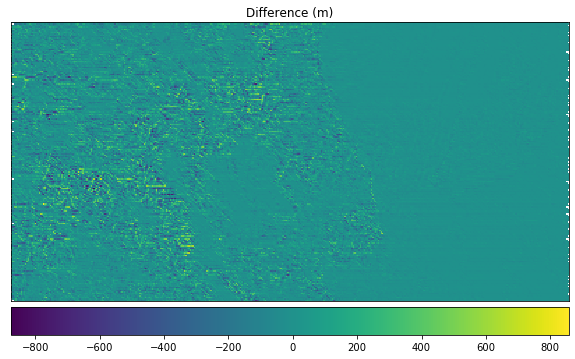

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
#Plot difference
plt.figure(figsize=(10,10))
plt.title('Difference (m)')
plt.xticks([])
plt.yticks([])
plt.imshow(dem2-dem1)
plt.colorbar(orientation='horizontal',pad=0.01)

In [15]:
rmse = np.mean((dem1-dem2)**2)**0.5
abias = np.mean(np.abs(dem1-dem2))
print('RMSE: %f meters' % rmse)
print('aBIAS: %f meters' % abias)

RMSE: 100.470221 meters
aBIAS: 53.043501 meters


# 4. Rotating globe + precipitation (25 pts)

Following the example of rotating globe that was shown in Lecture 9, produce a rotating globe that shows time varying maps of precipitation on the globe. You will want to use precipitation from `/data/era-interim/era_interim_monthly_197901_201512_upscaled.nc_ann`. The variable name is `precip`. Feel free to use whatever frequency of rotation of the globe that you wish. 

In [16]:
import netCDF4 as nc
import numpy as np
file_era_interim = '/data/era-interim/era_interim_monthly_197901_201512_upscaled.nc_ann'
fpe = nc.Dataset(file_era_interim)
#Extract the lats and lons array
lat = fpe['lat'][:]
lon = fpe['lon'][:]
#Read in the temperature data
data = fpe['precip'][:]

/opt/conda/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/physical/ne_110m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/opt/conda/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/opt/conda/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/physical/ne_110m_lakes.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/opt/conda/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/physical/ne_110m_rivers_lake_centerlines.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


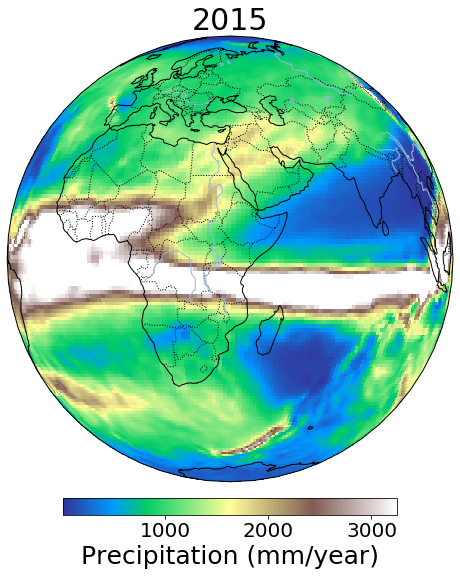

In [17]:
import cartopy
from matplotlib import animation, rc
from IPython.display import HTML

img_extent = (-180,180,-90,90)
fig = plt.figure(figsize=(10,10))
data = 365*data
vmin = np.percentile(data,2)
vmax = np.percentile(data,98)
years = np.arange(1979,2016)
nframes = years.size

# animation function. This is called sequentially
def animate(i):
    #Clear figure
    plt.clf()
    #Define central longitude
    central_longitude = np.linspace(-180,180,10+1)[0:-1][i%10]
    #Target projection
    ax = plt.axes(projection=cartopy.crs.Orthographic(central_longitude=central_longitude))
    #Source projection
    im = plt.imshow(data[i,:,:],vmin=vmin,vmax=vmax,
                    transform=cartopy.crs.PlateCarree(),
                    cmap=plt.get_cmap('terrain'),extent=(img_extent))
    plt.xticks([])
    plt.yticks([])
    #Let's add country borders, coastlines, major riverrs, and lakes
    ax.add_feature(cartopy.feature.COASTLINE)
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
    ax.add_feature(cartopy.feature.RIVERS)
    #Add the colorbar
    cb = plt.colorbar(ax=ax,orientation='horizontal',shrink=0.6,pad=0.03)
    cb.ax.tick_params(labelsize=20)
    cb.ax.set_xlabel('Precipitation (mm/year)',fontsize=25)
    plt.title('%04d' % (years[i],),fontsize=30)
    return (im,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate,frames=nframes, interval=500, blit=True)

HTML(anim.to_html5_video())